In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import chardet

# Detect file encoding first
with open("C:\\Users\\azhar\\Downloads\\1postings.csv", 'rb') as f:
    result = chardet.detect(f.read(100000))  # Check first 100KB

print(f"Detected encoding: {result['encoding']}")

# Load with detected encoding
try:
    df = pd.read_csv("C:\\Users\\azhar\\Downloads\\1postings.csv", encoding=result['encoding'])
except:
    # Fallback to latin1 if detection fails
    df = pd.read_csv("C:\\Users\\azhar\\Downloads\\1postings.csv", encoding='latin1')

# Basic cleaning
df = df.dropna(how='all')  # Remove completely empty rows
df = df.drop_duplicates()  # Remove duplicates

# Convert relevant columns to string type
text_cols = ['title', 'company', 'description', 'location']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)

print(f"Data loaded with {len(df)} records")
print(df.head())

Detected encoding: Windows-1254
Data loaded with 123849 records
     job_id            company_name  \
0    921716   Corcoran Sawyer Smith   
1   1829192                     NaN   
2  10998357  The National Exemplar    
3  23221523  Abrams Fensterman, LLP   
4  35982263                     NaN   

                                               title  \
0                              Marketing Coordinator   
1                  Mental Health Therapist/Counselor   
2                        Assitant Restaurant Manager   
3  Senior Elder Law / Trusts and Estates Associat...   
4                                 Service Technician   

                                         description  max_salary pay_period  \
0  Job descriptionA leading real estate firm in N...        20.0     HOURLY   
1  At Aspen Therapy and Wellness , we are committ...        50.0     HOURLY   
2  The National Exemplar is accepting application...     65000.0     YEARLY   
3  Senior Associate Attorney - Elder Law / Trust

In [ ]:
# Clean job titles
df['title'] = df['title'].str.strip().str.lower()

# Extract skills from descriptions
skills_keywords = {
    'python': ['python', 'pandas', 'numpy', 'scikit-learn'],
    'sql': ['sql', 'mysql', 'postgresql', 'sql server'],
    'r': ['r ', 'rstudio', ' r '],
    'excel': ['excel', 'advanced excel'],
    'tableau': ['tableau'],
    'powerbi': ['power bi', 'powerbi'],
    'machine_learning': ['machine learning', 'ml ', ' ai ', 'deep learning'],
    'statistics': ['statistics', 'statistical'],
    'spark': ['spark', 'pyspark'],
    'hadoop': ['hadoop'],
    'aws': ['aws', 'amazon web services'],
    'azure': ['azure'],
    'gcp': ['gcp', 'google cloud'],
    'data_visualization': ['data visualization', 'visualization'],
    'big_data': ['big data', 'hadoop', 'spark'],
    'nosql': ['nosql', 'mongodb', 'cassandra']
}

def extract_skills(description):
    found_skills = []
    description = description.lower()
    for skill, keywords in skills_keywords.items():
        for keyword in keywords:
            if keyword in description:
                found_skills.append(skill)
                break  # No need to check other keywords for this skill
    return list(set(found_skills))  # Remove duplicates

# Apply skill extraction
df['skills'] = df['description'].apply(extract_skills)

# Clean location data
df['location'] = df['location'].str.split(',').str[0].str.strip()

print("Data preprocessing completed")
print(df[['title', 'company', 'location', 'skills']].head())

C:\Users\azhar\AppData\Local\Temp\ipykernel_6500\284024384.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=skill_counts.values, y=skill_counts.index, palette='viridis')


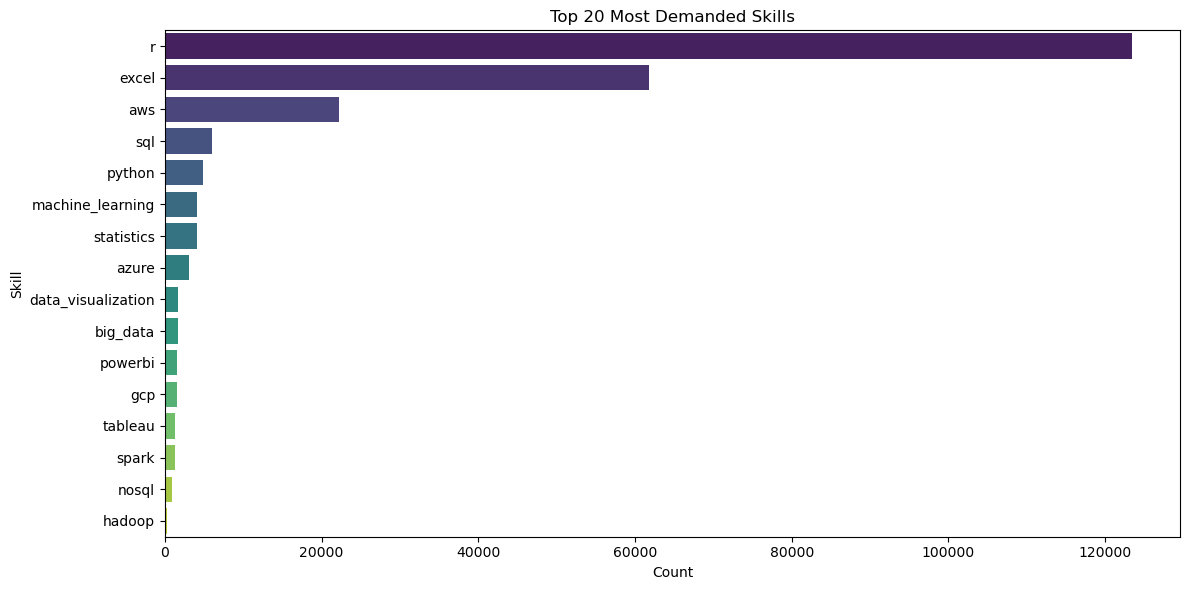

In [9]:
# Flatten skills list and count occurrences
all_skills = [skill for sublist in df['skills'] for skill in sublist]
skill_counts = pd.Series(all_skills).value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=skill_counts.values, y=skill_counts.index, palette='viridis')
plt.title('Top 20 Most Demanded Skills')
plt.xlabel('Count')
plt.ylabel('Skill')
plt.tight_layout()
plt.savefig('top_skills.png', dpi=300)
plt.show()

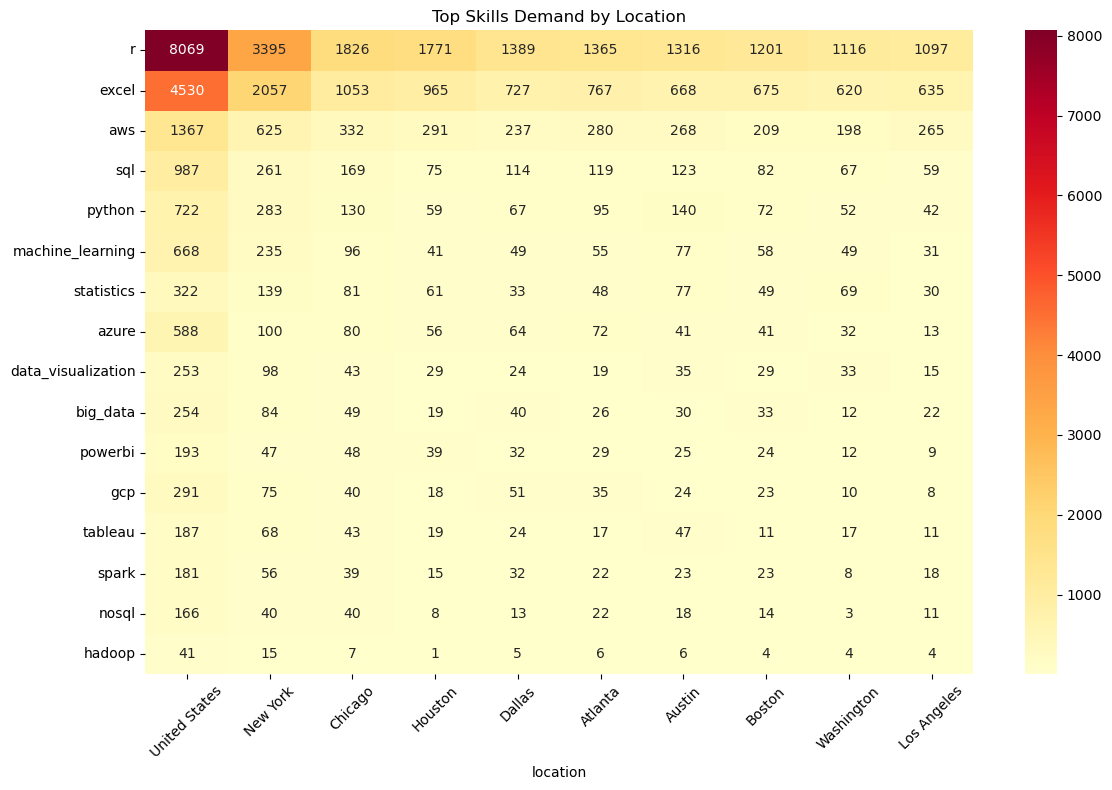

In [11]:
# Get top 10 locations
top_locations = df['location'].value_counts().head(10).index

# Create skill-location matrix
skill_location = pd.DataFrame(index=skill_counts.index, columns=top_locations)

for location in top_locations:
    loc_skills = [skill for sublist in df[df['location'] == location]['skills'] for skill in sublist]
    skill_counts_loc = pd.Series(loc_skills).value_counts()
    skill_location[location] = skill_counts_loc

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(skill_location.fillna(0), cmap='YlOrRd', annot=True, fmt='g')
plt.title('Top Skills Demand by Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('skills_by_location.png', dpi=300)
plt.show()

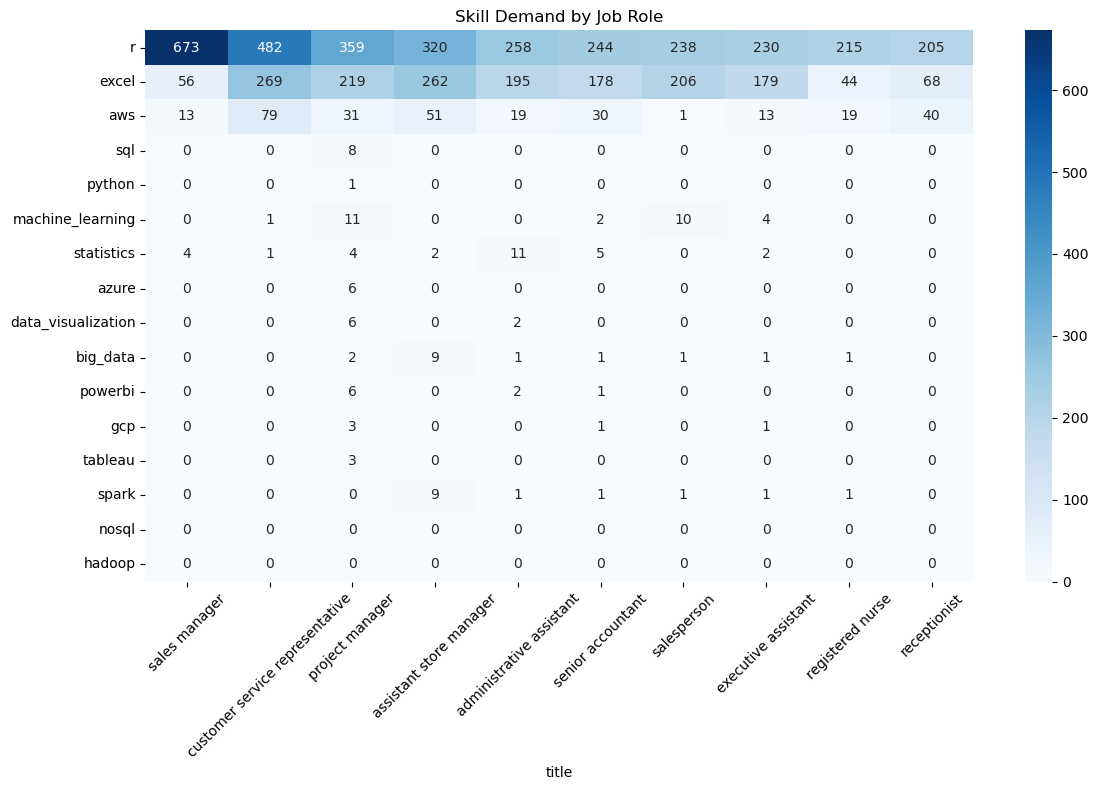

In [13]:
# Get top 10 job titles
top_titles = df['title'].value_counts().head(10).index

# Create skill-role matrix
skill_role = pd.DataFrame(index=skill_counts.index, columns=top_titles)

for title in top_titles:
    title_skills = [skill for sublist in df[df['title'] == title]['skills'] for skill in sublist]
    skill_counts_title = pd.Series(title_skills).value_counts()
    skill_role[title] = skill_counts_title

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(skill_role.fillna(0), cmap='Blues', annot=True, fmt='g')
plt.title('Skill Demand by Job Role')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('skills_by_role.png', dpi=300)
plt.show()

In [15]:
def generate_recommendations(df, target_location=None, target_role=None):
    recommendations = []
    
    # Overall market trends
    top_skills_overall = skill_counts.head(5).index.tolist()
    recommendations.append(
        f"Top 5 skills in demand overall: {', '.join(top_skills_overall)}"
    )
    
    # Location-specific recommendations
    if target_location:
        if target_location in df['location'].unique():
            loc_skills = [skill for sublist in df[df['location'] == target_location]['skills'] 
                         for skill in sublist]
            top_loc_skills = pd.Series(loc_skills).value_counts().head(5).index.tolist()
            recommendations.append(
                f"Top 5 skills in {target_location}: {', '.join(top_loc_skills)}"
            )
        else:
            recommendations.append(
                f"Location '{target_location}' not found in dataset. Showing overall trends instead."
            )
    
    # Role-specific recommendations
    if target_role:
        matching_titles = df[df['title'].str.contains(target_role, case=False)]['title'].unique()
        if len(matching_titles) > 0:
            role_skills = [skill for sublist in df[df['title'].str.contains(target_role, case=False)]['skills'] 
                          for skill in sublist]
            top_role_skills = pd.Series(role_skills).value_counts().head(5).index.tolist()
            recommendations.append(
                f"Top 5 skills for {target_role} roles: {', '.join(top_role_skills)}"
            )
        else:
            recommendations.append(
                f"No jobs found matching '{target_role}'. Showing overall trends instead."
            )
    
    # Emerging skills (looking for less common but growing skills)
    mid_freq_skills = skill_counts[skill_counts.between(skill_counts.quantile(0.3), skill_counts.quantile(0.6))].index.tolist()
    recommendations.append(
        f"Emerging skills to consider: {', '.join(np.random.choice(mid_freq_skills, size=3, replace=False))}"
    )
    
    return recommendations

# Example usage
print("\nJob Market Recommendations:")
for rec in generate_recommendations(df, target_location="New York", target_role="data"):
    print(f"- {rec}")


Job Market Recommendations:
- Top 5 skills in demand overall: r, excel, aws, sql, python
- Top 5 skills in New York: r, excel, aws, python, sql
- Top 5 skills for data roles: r, excel, sql, python, aws
- Emerging skills to consider: data_visualization, powerbi, azure
